# Text Based Mood Classifier (Team 10)

### Project Description
Because of COVID-19, many people are suffering from difficulties about mental health. Thus, this project aims to predict people’s emotional state from text data to prevent some mental illnesses. 
 
We classify some text messages by people into joy, fear, anger, and sadness to construct a prediction model and use it. In the process, we used NLP techniques and random forest algorithm. 
 
We expect that these attempts will help to develop application programs that can record a person's emotional changes and utilize it. For example, if the app detects any dangerous signals from the user, such as depression or suicide, it may be able to connect him/her to a counseling center, of course, based on a clear agreement of the user.

### References
[Emotion Classification NLP](https://www.kaggle.com/jorelmb/emotion-classification-nlp) : We refered to some preprocessing techniques from here.



In [44]:
from pprint import pprint
!pip install emoji

# Setup
import os
import re
import time

import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from keras_preprocessing.text import Tokenizer
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.utils.validation import check_is_fitted

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')

random_state = 143

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


## Load dataset
[Data from Kaggle: Emotion Classification NLP](https://www.kaggle.com/anjaneyatripathi/emotion-classification-nlp)

: Tweets classified based on 4 emotions - joy, sadness, anger and fear.

In [30]:
def load_emotion_data(dataset):
    """
    Loads the required dataset from the emotions input
    :param dataset:
    :return:
    """
    base_path = './archive/'
    dataset_name = 'emotion-labels-%s.csv' % dataset

    data = pd.read_csv(os.path.join(base_path, dataset_name))
    return data['text'].values, data['label'].values

train_X, train_y = load_emotion_data('train')
val_X, val_y = load_emotion_data('val')
test_X, test_y = load_emotion_data('test')


## NLP Processing

### Vectorizer 
We decide to use vectorizer to apply sentences that have completed NLP preprocessing to the random forest model.

In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(train_X)

vocabulary = pd.DataFrame(vectorizer.vocabulary_.items(), columns=['word', 'count'])
vocabulary['length'] = vocabulary.apply(lambda x: len(x[0]), axis=1)

### Lower
This is a new class using what we've learned. This class changes all sentences to lowercase to remove the stop word later.

In [32]:
class Lower(TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        values = pd.Series(X)
        
        for i in range(values.size):
            values[i] = values[i].lower()
        
        return values

lower_words = Lower()
print(lower_words.fit_transform(train_X[:10]))

0    just got back from seeing @garydelaney in burs...
1    oh dear an evening of absolute hilarity i don'...
2    been waiting all week for this game ❤️❤️❤️ #ch...
3    @gardiner_love : thank you so much, gloria! yo...
4    i feel so blessed to work with the family that...
5    today i reached 1000 subscribers on yt!! , #go...
6    @singaholic121 good morning, love! happy first...
7    #bridgetjonesbaby is the best thing i've seen ...
8    just got back from seeing @garydelaney in burs...
9    @indymn i thought the holidays could not get a...
dtype: object


### Remove Handles & Coded values
Since the dataset is from Twitter, we need to erase things like ID tags(@), ect.

In [33]:
class RemoveHandles(TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'@\w+', '', regex=True).values

remove_handles = RemoveHandles()
print(remove_handles.fit_transform(train_X[:10]))

['just got back from seeing  in burslem. amazing!! face still hurts from laughing so much #hilarious'
 "oh dear an evening of absolute hilarity i don't think i have laughed so much in a long time! 😂"
 'been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️'
 " : thank you so much, gloria! you're so sweet, and thoughtful! you just made my day more joyful! i love you too! 😊💕"
 'i feel so blessed to work with the family that i nanny for ❤️ nothing but love &amp; appreciation, makes me smile.'
 'today i reached 1000 subscribers on yt!! , #goodday, #thankful'
 " good morning, love! happy first day of fall. let's make some awesome #autumnmemories #annabailey #laughter #smile"
 "#bridgetjonesbaby is the best thing i've seen in ages! so funny, i've missed bridget! #love  #teammark"
 'just got back from seeing  in burslem. amazing!! face still hurts from laughing so much '
 ' i thought the holidays could not get any more cheerful, and then i met you. #thenicebot']


In [34]:
class RemoveCodedValues(TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        values = pd.Series(X)
        return values.replace(r'&\w+;', '', regex=True).values

remove_coded = RemoveCodedValues()

pat = re.compile(r'&\w+;')
for f in remove_coded.fit_transform(train_X):
    found = pat.findall(f)
    if len(found) > 0:
        print(pat.findall(f))

### Process emojies
Emoticons are an important factor in expressing emotions. Thus, we need to change the emojies to a form that the model can handle.

In [35]:
class TokenizeEmoji(TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([emoji.demojize(text) for text in X])

tokenize_emoji = TokenizeEmoji()
test = tokenize_emoji.fit_transform(train_X[:10])

vectorizer.fit(test)
print(vectorizer.vocabulary_)

{'just': 56, 'got': 45, 'back': 13, 'from': 36, 'seeing': 82, 'garydelaney': 40, 'in': 52, 'burslem': 19, 'amazing': 4, 'face': 28, 'still': 89, 'hurts': 51, 'laughing': 58, 'so': 87, 'much': 71, 'hilarious': 48, 'oh': 77, 'dear': 25, 'an': 6, 'evening': 27, 'of': 76, 'absolute': 1, 'hilarity': 49, 'don': 26, 'think': 100, 'have': 47, 'laughed': 57, 'long': 61, 'time': 104, 'face_with_tears_of_joy': 29, 'been': 14, 'waiting': 110, 'all': 3, 'week': 111, 'for': 34, 'this': 101, 'game': 38, 'red_heart': 81, 'cheer': 21, 'friday': 35, 'gardiner_love': 39, 'thank': 93, 'you': 114, 'gloria': 42, 're': 79, 'sweet': 91, 'and': 7, 'thoughtful': 103, 'made': 63, 'my': 72, 'day': 24, 'more': 69, 'joyful': 55, 'love': 62, 'too': 107, 'smiling_face_with_smiling_eyes': 86, 'two_hearts': 108, 'feel': 32, 'blessed': 16, 'to': 105, 'work': 113, 'with': 112, 'the': 96, 'family': 31, 'that': 95, 'nanny': 73, 'nothing': 75, 'but': 20, 'amp': 5, 'appreciation': 10, 'makes': 65, 'me': 66, 'smile': 85, 'tod

In [36]:
class Emojifier(TransformerMixin):
    """
    Converts characters like :) :( :/ to a unique value
    """
    def __init__(self, emoji_pattern=r'[:;Xx][)(\/D]|[)(\/D][:;]'):
        self.emoji_pattern = emoji_pattern

    def fit(self, X):
        emoji_list = set()
        pattern = re.compile(self.emoji_pattern)

        for line in X:
            emoji_list.update(pattern.findall(line))


        self.found_emojis_ = {}
        for i, emoji in enumerate(emoji_list):
            self.found_emojis_[emoji] = '<EMOJI_%d>' % i

        return self

    def transform(self, X):
        # Validate
        check_is_fitted(self, ['found_emojis_'])

        # Transform
        data = pd.Series(X)
        for emoji, name in self.found_emojis_.items():
            data = data.str.replace(emoji, name, regex=False)

        return data.values

emojifier = Emojifier()
emojifier.fit(train_X)
print(emojifier.found_emojis_)

emojified_X = emojifier.transform(train_X)

{':/': '<EMOJI_0>', '/:': '<EMOJI_1>', ';)': '<EMOJI_2>', 'xD': '<EMOJI_3>', ':(': '<EMOJI_4>', 'x)': '<EMOJI_5>', 'XD': '<EMOJI_6>', '):': '<EMOJI_7>', ':)': '<EMOJI_8>'}


This is for chicking if the Emojifier works well.

In [37]:
for i, val in enumerate(train_X[:100]):
    m = re.findall(r'[:;Xx][)(\/D]|[)(\/D][:;x]', val)
    if len(m) > 0:
        print(set(m))
        print(i, val, train_y[i])
        print(i, emojified_X[i])

{':)', ';)'}
23 Online now !!!:) all day come play with me !! I'm happy happy horny playful sweet sour;) joy
23 Online now !!!<EMOJI_8> all day come play with me !! I'm happy happy horny playful sweet sour<EMOJI_2>
{':)'}
25 @itsyourgirl_Z happy birthday :) have a blessed day love from Toronto :) #bday  joy
25 @itsyourgirl_Z happy birthday <EMOJI_8> have a blessed day love from Toronto <EMOJI_8> #bday 
{':)'}
27 Morning all! Of course it is sunny on this Monday morning to cheerfully welcome us back to work.:) joy
27 Morning all! Of course it is sunny on this Monday morning to cheerfully welcome us back to work.<EMOJI_8>
{'):'}
30 Retweeted GunnySmith93 (@Stephen21Smith):\n\nDays like today I am happy to be alive! #blessed #rejoice joy
30 Retweeted GunnySmith93 (@Stephen21Smith<EMOJI_7>\n\nDays like today I am happy to be alive! #blessed #rejoice
{'):'}
48 Retweeted GunnySmith93 (@Stephen21Smith):\n\nDays like today I am happy to be alive! #blessed  joy
48 Retweeted GunnySmith93 (@Steph

### Remove Stopwords
This is alos a new class using what we've learned.

In [38]:
class RemoveStopWords(TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
        values = pd.Series(X)
        
        stop_words = set(stopwords.words('english'))
        
        for i in range(values.size):
            temp = ""
            tokenize = values[i].split()
            for tok in tokenize:
                if tok not in stop_words:
                    temp = temp + tok + " "
            values[i] = temp
        
        return values

remove_stopwords = RemoveStopWords()
print(remove_stopwords.fit_transform(train_X[:10]))
    

0    got back seeing @garydelaney burslem. amazing!...
1    oh dear evening absolute hilarity think laughe...
2          waiting week game ❤️❤️❤️ #cheer #friday ❤️ 
3    @gardiner_love : thank much, gloria! sweet, th...
4    feel blessed work family nanny ❤️ nothing love...
5    today reached 1000 subscribers yt!! , #goodday...
6    @singaholic121 good morning, love! happy first...
7    #bridgetjonesbaby best thing i've seen ages! f...
8    got back seeing @garydelaney burslem. amazing!...
9    @indymn thought holidays could get cheerful, m...
dtype: object


## Pipeline
Applying all the processes so far to the dataset in order via pipeline.

In [39]:
pipeline = Pipeline([
    ("nlp", Lower()),
    ('handles', RemoveHandles()),
    ('coded', RemoveCodedValues()),
    ('emoji', TokenizeEmoji()),
    ('emojify', Emojifier()),
    ('stopword', RemoveStopWords()),
    ('counts', CountVectorizer())
])

prepared_train_X = pipeline.fit_transform(train_X)

## Apply Random Forest

In [40]:
rforest =  RandomForestClassifier(random_state=random_state, n_jobs=8)
rforest.fit(prepared_train_X, train_y)

RandomForestClassifier(n_jobs=8, random_state=143)

Accuracy on validation: 0.8414985590778098


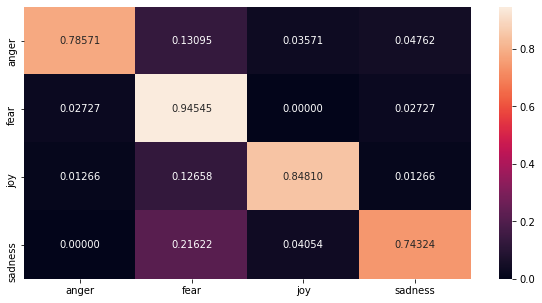

In [41]:
val_X_transformed = pipeline.transform(val_X)
val_y_predicted = rforest.predict(val_X_transformed)

accuracy = accuracy_score(val_y, val_y_predicted)
print('Accuracy on validation:', accuracy)

conf_matrix = confusion_matrix(val_y, val_y_predicted, normalize='true')
conf_matrix = pd.DataFrame(conf_matrix, columns=rforest.classes_, index=rforest.classes_)


plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='.5f')
plt.show()

## Result
We receive a sentence and classify the emotion of that sentence 

In [125]:
input_text = input("Text: ")

Text: hello! nice to see you


In [126]:
print(input_text)

hello! nice to see you


In [127]:
input_text_transformed = pipeline.transform(input_text)
input_predict = rforest.predict(input_text_transformed)

print(input_predict)

['fear']
